# Student Performance Prediction with Linear Regression

Importing libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

Loading the Portuguese Student dataset, because it has more samples to train on.

In [2]:
df = pd.read_csv("student-por.csv", sep=";")

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
# Checking the structure of the dataset
df.info()

# Checking for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

We have quite a few categorical features in the dataset, for further analysis, they must be converted into numerical values.

In [4]:
d = {"yes": 1, "no": 0}
df["higher"] = df["higher"].map(d)
df["paid"] = df["paid"].map(d)
df["schoolsup"] = df["schoolsup"].map(d)
df["famsup"] = df["famsup"].map(d)
df["nursery"] = df["nursery"].map(d)
df["internet"] = df["internet"].map(d)
df["activities"] = df["activities"].map(d)
df["romantic"] = df["romantic"].map(d)

d = {"M": 1, "F": 0}
df["sex"] = df["sex"].map(d)

d = {"U": 1, "R": 0}
df["address"] = df["address"].map(d)

d = {"LE3": 1, "GT3": 0}
df["famsize"] = df["famsize"].map(d)

d = {"T": 1, "A": 0}
df["Pstatus"] = df["Pstatus"].map(d)

d = {"home": 1, "reputation": 0, "course": 2, "other": 3}
df["reason"] = df["reason"].map(d)

d = {"mother": 1, "father": 0, "other": 2}
df["guardian"] = df["guardian"].map(d)

d = {"GP": 1, "MS": 0}
df["school"] = df["school"].map(d)

d = {"teacher": 1, "health": 0, "services": 2, "at_home": 3, "other": 4}
df["Mjob"] = df["Mjob"].map(d)
df["Fjob"] = df["Fjob"].map(d)

In [5]:
# Checking basic statistics
df.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,...,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,0.651772,0.409861,16.744222,0.696456,0.295840,0.876733,2.514638,2.306626,2.744222,3.069337,...,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,0.476776,0.492187,1.218138,0.460143,0.456771,0.328996,1.134552,1.099931,1.285929,1.175811,...,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,1.000000,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,3.000000,4.000000,...,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,4.000000,4.000000,...,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


Since we have everything in numerical values, we should check out correlation by plotting it on a heatmap.

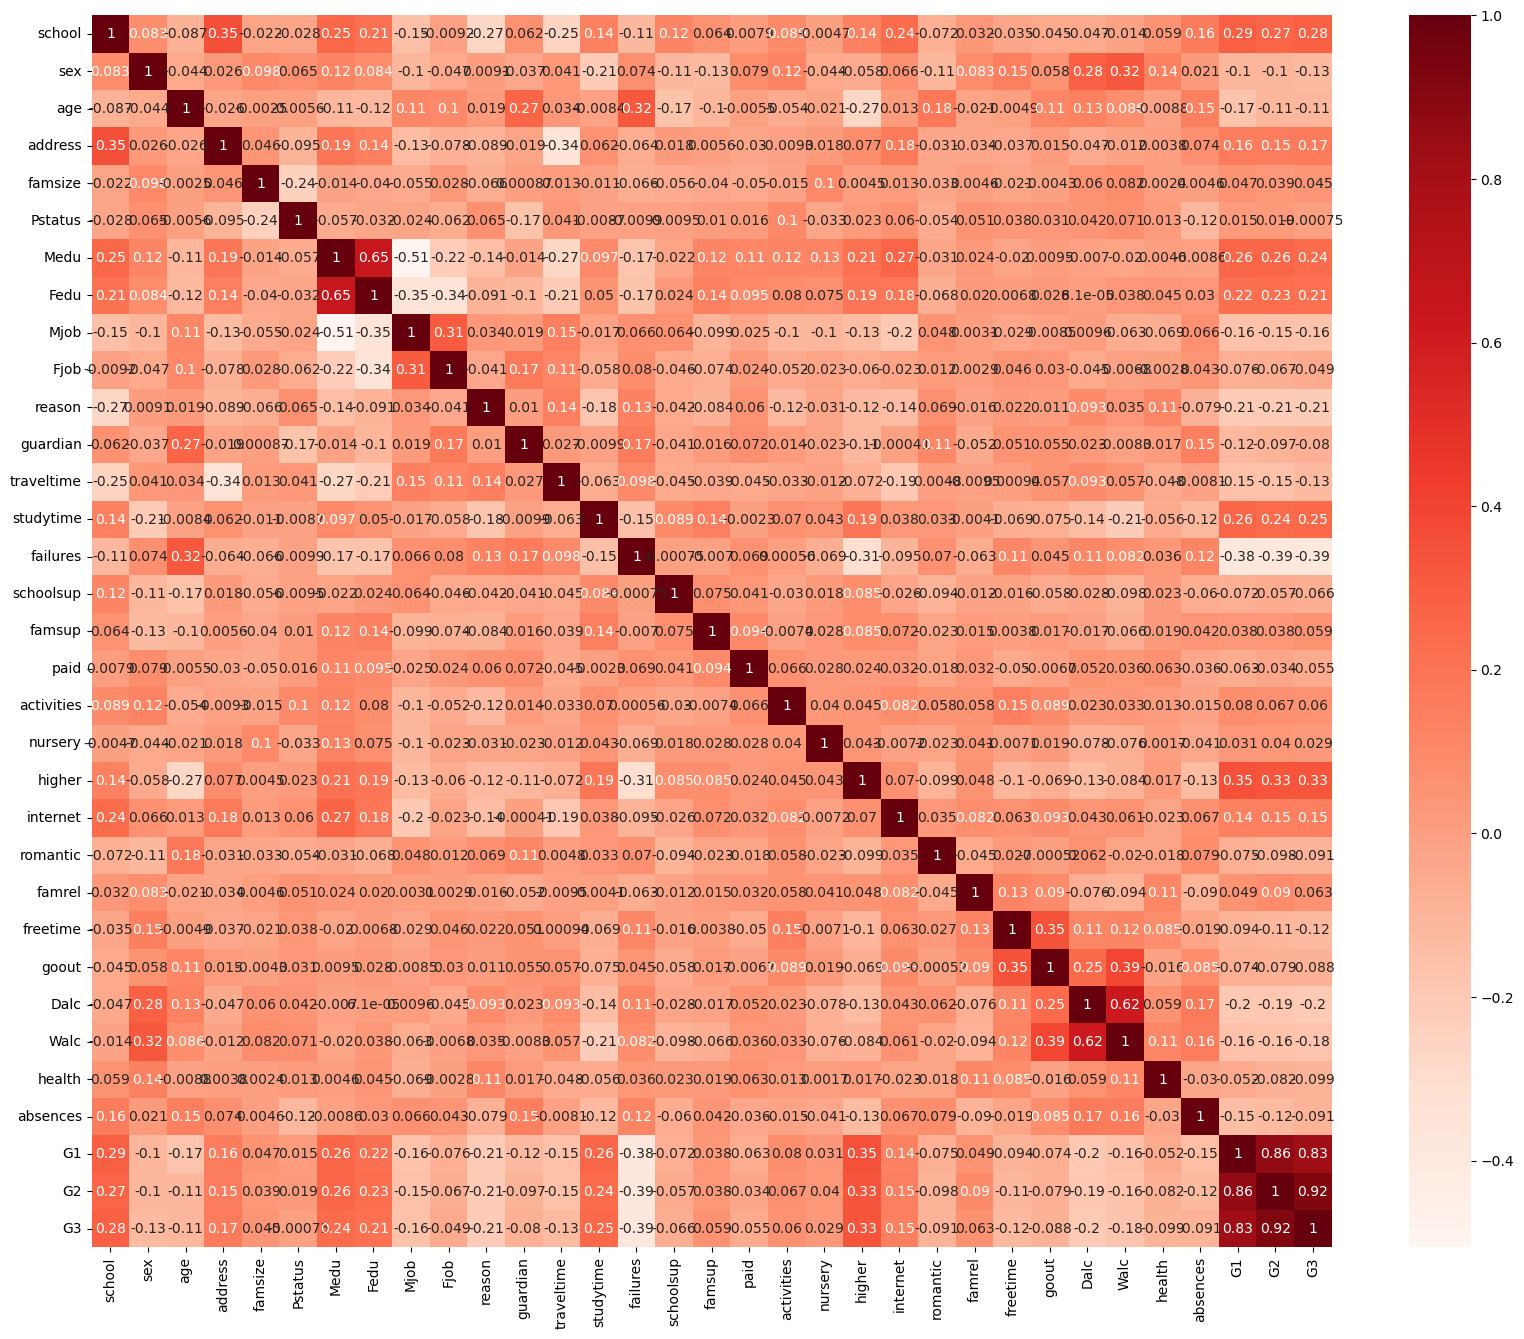

In [6]:
plt.figure(figsize=(20,16))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
cor_target = abs(cor["G3"])

relevant_features = cor_target[cor_target>0.5]
relevant_features

G1    0.826387
G2    0.918548
G3    1.000000
Name: G3, dtype: float64

It appear that only the grades have proper correlation between them.

Predefined a logarithmic sequence on alpha parameters range for RidgeCV and LassoCV models to choose and use.

In [8]:
alphas = np.logspace(-4, 4, 9)

This will allow us to utilize Cross-Validation for RidgeCV and LassoCV. By doing that, it chooses the best alpha value for itself.

Defined regression models and used Recursive Feature Elimination (RFE) to select the most important features.

In [9]:
target = "G3"

model = LinearRegression()
ridge_model = RidgeCV(alphas=alphas)
lasso_model = LassoCV(alphas=alphas)

rfe = RFE(model, n_features_to_select=10)
ridge_rfe = RFE(model, n_features_to_select=10)
lasso_rfe = RFE(model, n_features_to_select=10)

X = df.drop(columns=[target])
y = df[target]

rfe.fit(X, y)
ridge_rfe.fit(X, y)
lasso_rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
ridge_selected_features = X.columns[ridge_rfe.support_]
lasso_selected_features = X.columns[lasso_rfe.support_]

# Selected features that intersects with each model choices
features = selected_features.intersection(ridge_selected_features).intersection(lasso_selected_features)

Splitting data into train and test:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

Defining evaluation function to create scatter plots for our regression models:

In [11]:
def Evaluate(actual, prediction):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=prediction, label="Predicted", color="blue", s=100)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Linear Regression Line")
    plt.xlabel('Actual grades')
    plt.ylabel('Predicted grades')
    plt.title('Actual vs Predicted Grades')
    plt.legend()
    plt.show()

Trained and tested simple Linear Regression model with our data:

LR Mean Squared Error: 1.266969639120811
LR R-squared: 0.8700772620740898


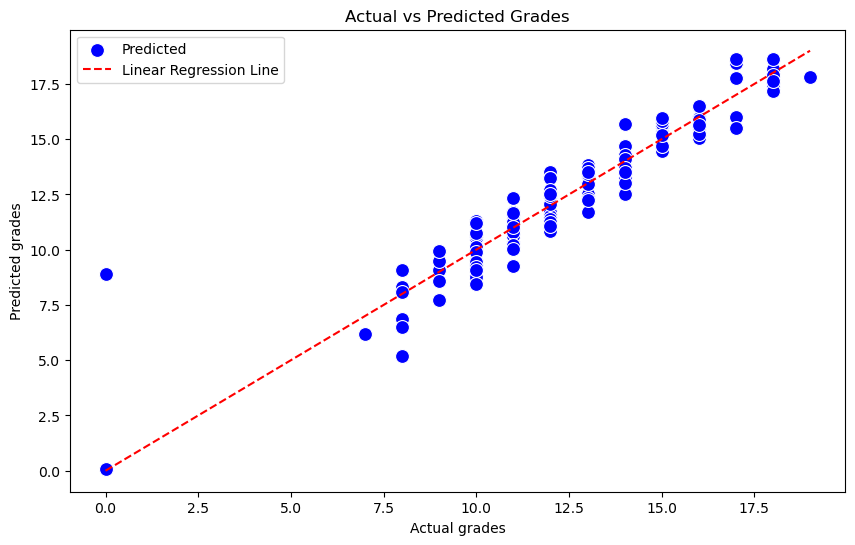

In [12]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"LR Mean Squared Error: {mse}")
print(f"LR R-squared: {r2}")
Evaluate(y_test, y_pred)

Trained and tested RidgeCV model with our data:

In [13]:
ridge_model.fit(X_train, y_train)

best_alpha_ridge = ridge_model.alpha_
print(f"Best alpha for Ridge model: {best_alpha_ridge}")

Best alpha for Ridge model: 100.0


Ridge Mean Squared Error: 1.226420543046386
Ridge R-squared: 0.8742354118984739


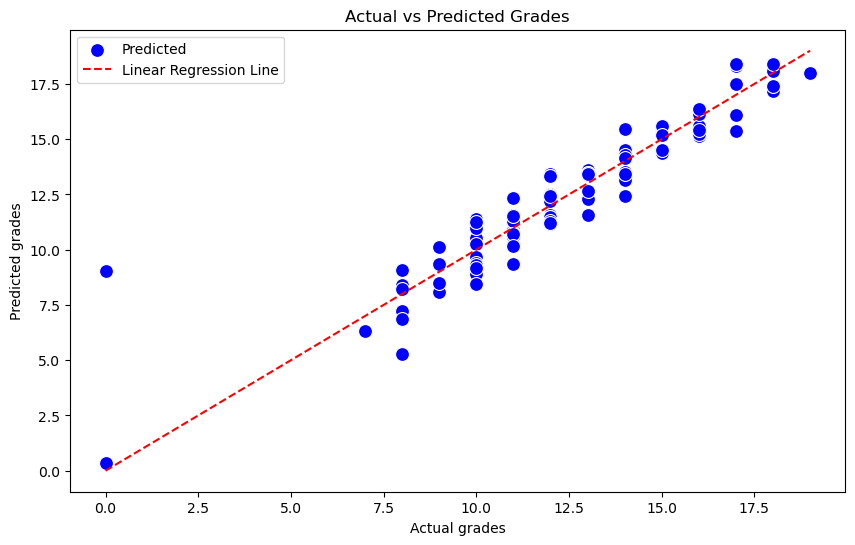

In [14]:
y_pred_ridge = ridge_model.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Mean Squared Error: {mse_ridge}")
print(f"Ridge R-squared: {r2_ridge}")
Evaluate(y_test, y_pred_ridge)

Trained and tested LassoCV model with our data:

In [15]:
lasso_model.fit(X_train, y_train)

best_alpha_lasso = lasso_model.alpha_
print(f"Best alpha for Lasso model: {best_alpha_lasso}")

Best alpha for Lasso model: 0.01


Lasso Mean Squared Error: 1.2695251885086776
Lasso R-squared: 0.8700772620740898


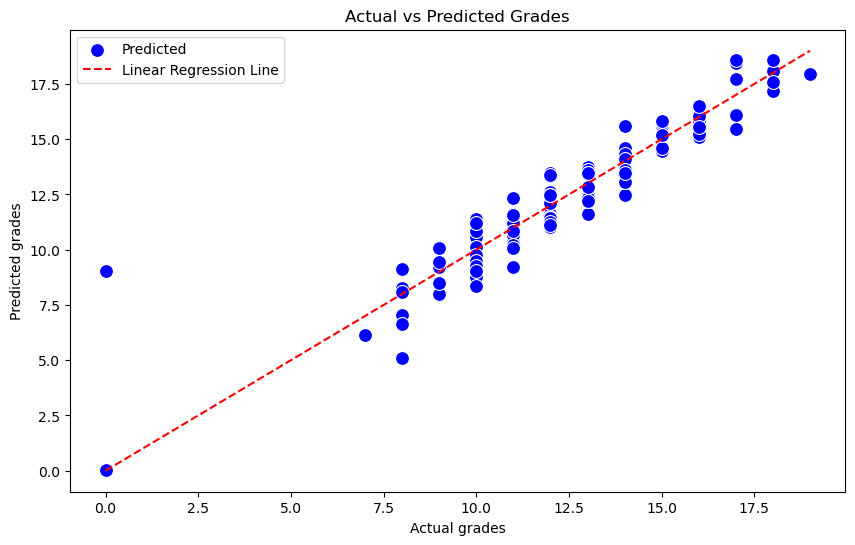

In [16]:
y_pred_lasso = lasso_model.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Mean Squared Error: {mse_lasso}")
print(f"Lasso R-squared: {r2}")
Evaluate(y_test, y_pred_lasso)

Since we are finished with model training and testing, let's compare the accuraccy between the models.

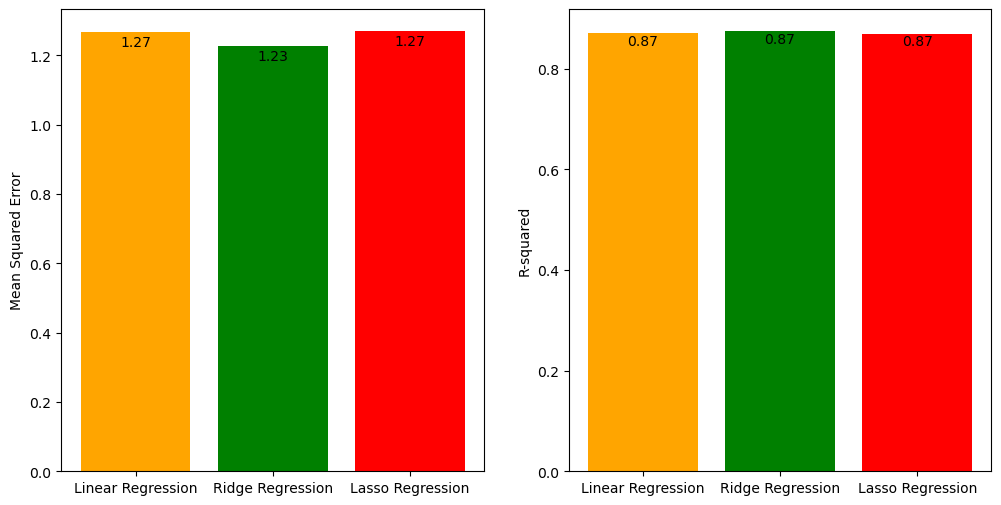

In [17]:
models = ["Linear Regression", "Ridge Regression", "Lasso Regression"]
mse_values = [mse, mse_ridge, mse_lasso]
r2_values = [r2, r2_ridge, r2_lasso]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(models, mse_values, color=["orange", "green", "red"])
axs[0].set_ylabel("Mean Squared Error")
for i, value in enumerate(mse_values):
    axs[0].text(i, value - 0.01, f"{value:.2f}", ha="center", va="top")

# Plot R-squared
axs[1].bar(models, r2_values, color=["orange", "green", "red"])
axs[1].set_ylabel("R-squared")
for i, value in enumerate(r2_values):
    axs[1].text(i, value - 0.001, f"{value:.2f}", ha="center", va="top")

plt.show()

We have very minimal differences between the model MSE's and seems like no differences for the R-squared values\
That beeing said, let's compare these values on the microscopic level and define the winner.

In [18]:
index = r2_values.index(max(r2_values))
models[index]

'Ridge Regression'

Let's apply our winning model to Math Student dataset.

In [19]:
df = pd.read_csv("student-mat.csv", sep=";")

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [20]:
d = {"yes": 1, "no": 0}
df["higher"] = df["higher"].map(d)
df["paid"] = df["paid"].map(d)
df["schoolsup"] = df["schoolsup"].map(d)
df["famsup"] = df["famsup"].map(d)
df["nursery"] = df["nursery"].map(d)
df["internet"] = df["internet"].map(d)
df["activities"] = df["activities"].map(d)
df["romantic"] = df["romantic"].map(d)

d = {"M": 1, "F": 0}
df["sex"] = df["sex"].map(d)

d = {"U": 1, "R": 0}
df["address"] = df["address"].map(d)

d = {"LE3": 1, "GT3": 0}
df["famsize"] = df["famsize"].map(d)

d = {"T": 1, "A": 0}
df["Pstatus"] = df["Pstatus"].map(d)

d = {"home": 1, "reputation": 0, "course": 2, "other": 3}
df["reason"] = df["reason"].map(d)

d = {"mother": 1, "father": 0, "other": 2}
df["guardian"] = df["guardian"].map(d)

d = {"GP": 1, "MS": 0}
df["school"] = df["school"].map(d)

d = {"teacher": 1, "health": 0, "services": 2, "at_home": 3, "other": 4}
df["Mjob"] = df["Mjob"].map(d)
df["Fjob"] = df["Fjob"].map(d)

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,0,0,4,4,3,1,...,4,3,4,1,1,3,6,5,6,6
1,1,0,17,1,0,1,1,1,3,4,...,5,3,3,1,1,3,4,5,5,6
2,1,0,15,1,1,1,1,1,3,4,...,4,3,2,2,3,3,10,7,8,10
3,1,0,15,1,0,1,4,2,0,2,...,3,2,2,1,1,5,2,15,14,15
4,1,0,16,1,0,1,3,3,4,4,...,4,3,2,1,2,5,4,6,10,10


In [21]:
X = df[features]
y = df[target]

Mean Squared Error: 4.385777809670183
R-squared: 0.7905197912107796


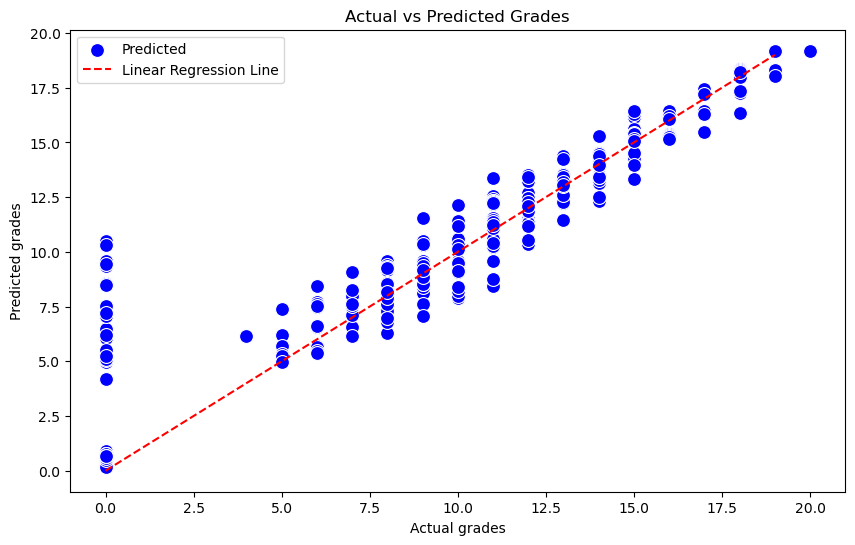

In [22]:
prediction = ridge_model.predict(X)

mse_ridge = mean_squared_error(y, prediction)
r2_ridge = r2_score(y, prediction)
print(f"Mean Squared Error: {mse_ridge}")
print(f"R-squared: {r2_ridge}")
Evaluate(y, prediction)

Results are definitely worse than with the Portuguese dataset. It appears that model incorrectly predicted students who failed final test and gave them below average grade.\
Let's look into the data:

In [23]:
df_fail = X
df_fail[target] = y
df_fail["pred"] = prediction
df_fail = df_fail[df_fail[target] == 0] 

C:\Users\Neriukas\AppData\Local\Temp\ipykernel_49884\3038622356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail[target] = y
C:\Users\Neriukas\AppData\Local\Temp\ipykernel_49884\3038622356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail["pred"] = prediction


In [24]:
print(df_fail.mean(axis=0))
print(df_fail.mode(axis=0))

school        0.894737
sex           0.394737
address       0.736842
traveltime    1.605263
failures      0.921053
schoolsup     0.026316
famsup        0.605263
paid          0.210526
higher        0.842105
G2            4.657895
G3            0.000000
pred          5.079556
dtype: float64
    school  sex  address  traveltime  failures  schoolsup  famsup  paid  \
0      1.0  0.0      1.0         1.0       0.0        0.0     1.0   0.0   
1      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
2      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
3      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
4      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
5      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
6      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
7      NaN  NaN      NaN         NaN       NaN        NaN     NaN   NaN   
8      NaN  NaN      NaN         N

From the means and modes above, we can deduct that students who received less educational support from their school and did not have extra paid classes on the subject, failed the final assessment.

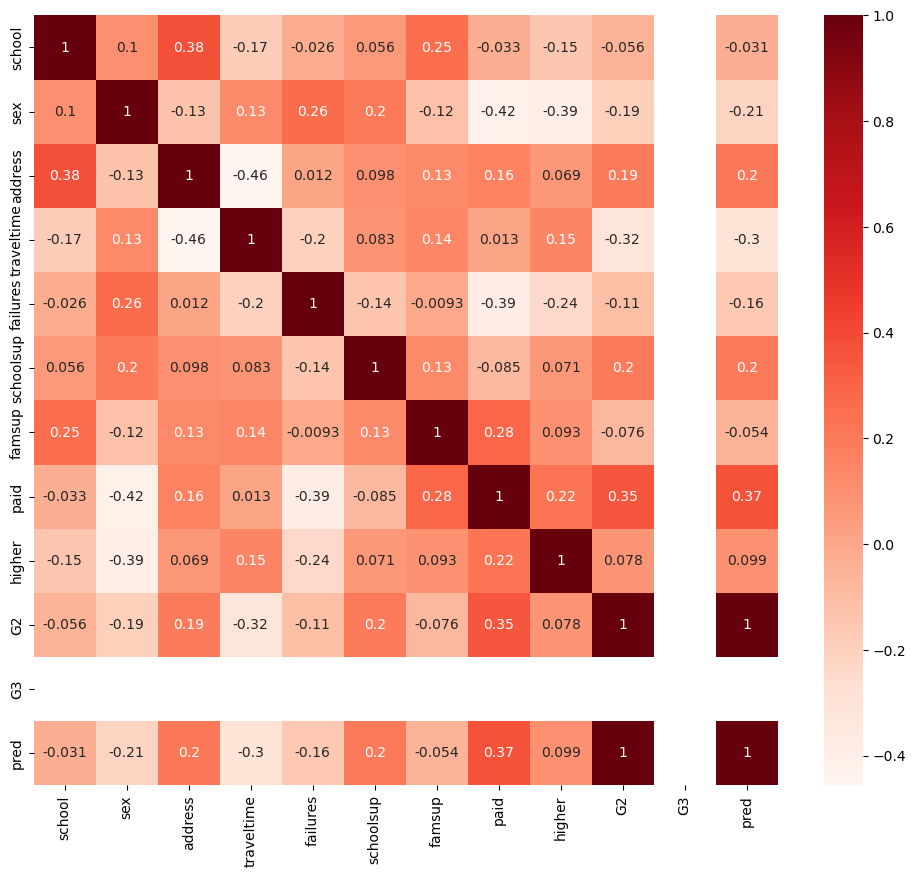

In [25]:
plt.figure(figsize=(12,10))
cor = df_fail.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
# Math fail ratio
failed = len(df_fail[df_fail[target] == 0])
all = len(X)
print(failed / all)

0.09620253164556962


In [27]:
df[["G1", "G2"]].describe()

,G1,G2
count,395.000000,395.000000
mean,10.908861,10.713924
std,3.319195,3.761505
min,3.000000,0.000000
25%,8.000000,9.000000
50%,11.000000,11.000000
75%,13.000000,13.000000
max,19.000000,19.000000


It looks like model put the most weight on G2 feature when predicting target values. There's a direct relationship between G2 and predictions on G3.\
In conclusion, the bar of passing Portuguese subject is lower than passing Math subject. Almost 10% of Math studets with similar feature values to Portuguese students, failed the final grade.